In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_paper2019/mplstyles


In [2]:
import prob_dist as pd
import EdwRes as er
import time
import imp
imp.reload(pd)

#get the resolutions                                                                              
sigHv,sigIv,sigQerv,sigH_NRv,sigI_NRv,sigQnrv = \
 er.getEdw_det_res('GGA3',4.0,'data/edw_res_data.txt',aH=0.0381,C=None) 

fF = pd.QEr_v2_2D_fast(sigHv,sigIv,4.0,3.0,0.00000001,Qbar=lambda x: 0.16*x**0.18)                            
gF = pd.expband_2D(fF,(1/18.0),1.5)



start = time.time()
fF(0.1,10.0,10.0)
end = time.time()
print('Analytic Expression: {:1.5f} sec.'.format(end-start))

start = time.time()
gF(0.1,10.0)
end = time.time()
print('Numerical Integration: {:1.5f} sec.'.format(end-start))

start = time.time()
pd.analytical_NRQ_dist(0.1) 
end = time.time()
print('Analytic Integration: {:1.5f} sec.'.format(end-start))

start = time.time()
np.sqrt(pd.analytical_NRQ_var(10))
end = time.time()
print('Analytic Integration (sigma): {:1.5f} sec.'.format(end-start))

start = time.time()
np.sqrt(pd.series_NRQ_var(100,A=1.0,B=0.0))
end = time.time()
print('Series Approximation (sigma): {:1.5f} sec.'.format(end-start))

start = time.time()
sigQnrv(10)
end = time.time()
print('Edw. Expression (sigma): {:1.5f} sec.'.format(end-start))

start = time.time()
pd.sigmomEdw(20,band='NR',label='GGA3',F=0.000001,V=4.0,aH=0.0381,alpha=(1/18.0))
end = time.time()
print('Normalization and Integration: {:1.5f} sec.'.format(end-start))

start = time.time()
np.sin(np.pi)
end = time.time()
print('sin function: {:1.5f} sec.'.format(end-start))

Analytic Expression: 0.00104 sec.
Numerical Integration: 0.18224 sec.
sa: 0.4058119182699013
sb: 1.4218603979228415
sc: 0.0
aq: 292.48016788400236
bq: 18.7037411059892
cq: 39.80700725263484
dq: 15.609908537820028
eq: 21.64723141425274
norm: 0.0006762654479378474
Analytic Integration: 0.00227 sec.
Analytic Integration (sigma): 0.00312 sec.
TEdw: 0.0022018179907194006
sqrt(TEdw): 0.04692353344239328
T1: 0.0020620666500234734
T2: 2.170371073839844e-06
T3: 4.4381533323415e-06
T4: 7.920735671539226e-06
T5: 1.3592226215354228e-05
T6: 9.046132982356797e-08
Series Approximation (sigma): 0.00342 sec.
Edw. Expression (sigma): 0.00033 sec.
Normalization and Integration: 40.17553 sec.
sin function: 0.00010 sec.


In [3]:
#check how the means and norms change
from scipy.integrate import quad

for Er in np.arange(10,200,50):
  norm = quad(gF,-1,4,args=(Er,),epsabs=1e-10)[0]
  Qdist = lambda Q: (1/norm)*gF(Q,Er)
  meanfun = lambda Q: Q*Qdist(Q)
  mean = quad(meanfun,-1,4,epsabs=1e-10)[0]
  print('energy: {:2.6f}'.format(Er))
  print('calc mean: {:2.6f}; Qmean: {:2.6f}'.format(mean,0.16*Er**0.18))
  print('calc norm: {:2.8f};'.format(norm))
  #sigfun = lambda Q: Q**2*Qdist(Q)
  #q2 = quad(sigfun,-1,4)[0]

energy: 10.000000
calc mean: 0.242241; Qmean: 0.242170
calc norm: 10.32813952;
energy: 60.000000
calc mean: 0.334199; Qmean: 0.334339
calc norm: 0.64214199;
energy: 110.000000
calc mean: 0.372412; Qmean: 0.372881
calc norm: 0.04000521;
energy: 160.000000
calc mean: 0.398058; Qmean: 0.398898
calc norm: 0.00249732;


In [4]:
alpha = (1/18.0)
print('norm ratio: {:2.3f}; expected ratio: {:2.3f}'.format(0.64214199/10.32813952,np.exp(-alpha*60)/np.exp(-alpha*10)))
print('norm ratio: {:2.3f}; expected ratio: {:2.3f}'.format(0.04000521/10.32813952,np.exp(-alpha*110)/np.exp(-alpha*10)))
print('norm ratio: {:2.8f}; expected ratio: {:2.8f}'.format(0.00249732/10.32813952,np.exp(-alpha*160)/np.exp(-alpha*10)))

norm ratio: 0.062; expected ratio: 0.062
norm ratio: 0.004; expected ratio: 0.004
norm ratio: 0.00024180; expected ratio: 0.00024037


In [5]:
from scipy import stats
Er = 20
norm = quad(gF,-1,4,args=(Er,),epsabs=1e-10)[0]
#norm = 10.32813952
Qdist = lambda Q: (1/norm)*gF(Q,Er)

In [6]:

print(Qdist(0.1))
Qdistv = np.vectorize(Qdist)
def randdist(x, pdf, nvals):
    """Produce nvals random samples from pdf(x), assuming constant spacing in x."""

    # get cumulative distribution from 0 to 1
    cumpdf = np.cumsum(pdf)
    cumpdf *= 1/cumpdf[-1]

    # input random values
    randv = np.random.uniform(size=nvals)

    # find where random values would go
    idx1 = np.searchsorted(cumpdf, randv)
    # get previous value, avoiding division by zero below
    idx0 = np.where(idx1==0, 0, idx1-1)
    idx1[idx0==0] = 1

    # do linear interpolation in x
    frac1 = (randv - cumpdf[idx0]) / (cumpdf[idx1] - cumpdf[idx0])
    randdist = x[idx0]*(1-frac1) + x[idx1]*frac1

    return randdist

start = time.time()
x = np.arange(-2,7,0.05)
print(np.std(randdist(x,Qdistv(x),1000)))
end = time.time()
print('sample function: {:1.5f} sec.'.format(end-start))

#get expected sig value
val = pd.sigmomEdw(20,band='NR',label='GGA3',F=0.000001,V=4.0,aH=0.0381,alpha=(1/18.0))
print(val)

0.0021722137542838317
0.04441038487616229
sample function: 4.04774 sec.
0.06117114823918761


In [7]:
x = np.arange(-2,1,0.01)

xmax = 1
n,nx = np.histogram(randdist(x,Qdistv(x),10000),100,range=(0,xmax))



xc = (nx[:-1] + nx[1:]) / 2

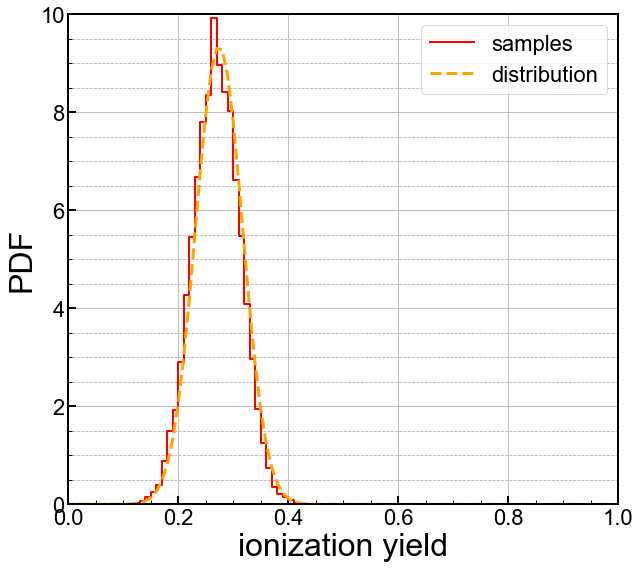

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ax1.step(xc,n/(np.sum(n)*(x[1]-x[0])), where='mid',color='r', linestyle='-', \
         label='samples', linewidth=2)

ax1.plot(x,Qdistv(x),color='orange',linestyle='--',linewidth=3,label='distribution')

ymin = 0
ymax = 10



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 1) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

TEdw: [4.02553791e+02 1.00639797e+02 4.47297983e+01 ... 1.90020659e-03
 1.90010558e-03 1.90000471e-03]
sqrt(TEdw): [20.06374318 10.03193885  6.68803396 ...  0.04359136  0.0435902
  0.04358904]
T1: [3.31500991e+02 8.28765457e+01 3.68349817e+01 ... 1.81369139e-03
 1.81360820e-03 1.81352514e-03]
T2: [1.20311717e+04 7.52155055e+02 1.48641929e+02 ... 1.33262634e-06
 1.33234803e-06 1.33207013e-06]
T3: [7.42890192e+04 4.64310726e+03 9.17171329e+02 ... 4.19451602e-06
 4.19444839e-06 4.19438087e-06]
T4: [4.39075749e+04 2.74497824e+03 5.42466423e+02 ... 4.86339923e-06
 4.86238352e-06 4.86136933e-06]
T5: [2.94667951e+05 1.84169036e+04 3.63795848e+03 ... 1.26899997e-05
 1.26897529e-05 1.26895066e-05]
T6: [9.27019171e+07 1.44848153e+06 1.27166418e+05 ... 8.77424075e-08
 8.77415795e-08 8.77407528e-08]


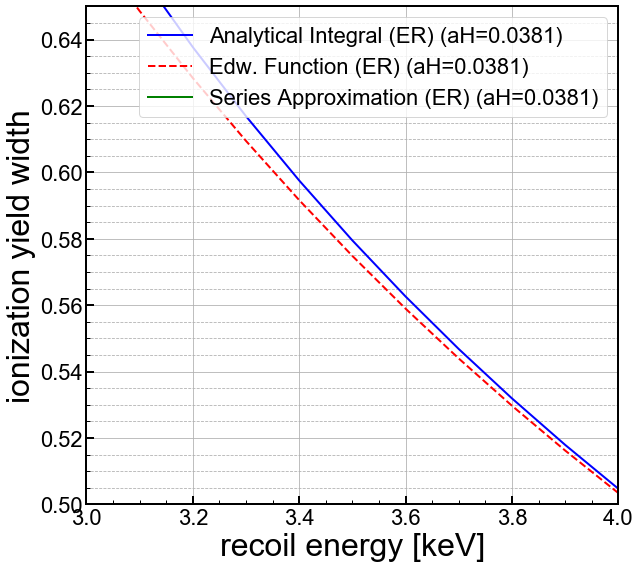

In [9]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

mask = [True, True, False, False, True, True, True, True, True]



X=np.arange(0.1,200,0.1)

ax1.plot(X,np.sqrt(pd.analytical_NRQ_var(X,A=1.0,B=0.0,alpha=0.0000001)),color='b',linestyle="-",linewidth=2, \
         label='Analytical Integral (ER) (aH={})'.format(0.0381))
ax1.plot(X,sigQerv(X),color='r',linestyle="--",linewidth=2, \
         label='Edw. Function (ER) (aH={})'.format(0.0381))
ax1.plot(X,np.sqrt(pd.series_NRQ_var(X,A=1.0,B=0.0,alpha=0.0000001)),color='g',linestyle="-",linewidth=2, \
         label='Series Approximation (ER) (aH={})'.format(0.0381))

#ax1.errorbar(xE,qbootsigs, yerr=(qbootsigerrsl,qbootsigerrsu), \
#             color='k', marker='o',markersize=4,linestyle='none',label='ER scatters', linewidth=2)
#ax1.errorbar(E_recoil_ER[mask],sig_ER[mask], yerr=sig_ER_err[mask], \
#             color='k', marker='^',markersize=8,linestyle='none',label='Edw. ER scatters', linewidth=2)




ymin = 0.5
ymax = 0.65



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(3, 4) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('pics/analytic_integral0.png')
plt.show()

TEdw: [4.02553791e+02 1.00639797e+02 4.47297983e+01 ... 1.90020659e-03
 1.90010558e-03 1.90000471e-03]
sqrt(TEdw): [20.06374318 10.03193885  6.68803396 ...  0.04359136  0.0435902
  0.04358904]
T1: [3.31500991e+02 8.28765457e+01 3.68349817e+01 ... 1.81369139e-03
 1.81360820e-03 1.81352514e-03]
T2: [1.20311717e+04 7.52155055e+02 1.48641929e+02 ... 1.33262634e-06
 1.33234803e-06 1.33207013e-06]
T3: [7.42890192e+04 4.64310726e+03 9.17171329e+02 ... 4.19451602e-06
 4.19444839e-06 4.19438087e-06]
T4: [4.39075749e+04 2.74497824e+03 5.42466423e+02 ... 4.86339923e-06
 4.86238352e-06 4.86136933e-06]
T5: [2.94667951e+05 1.84169036e+04 3.63795848e+03 ... 1.26899997e-05
 1.26897529e-05 1.26895066e-05]
T6: [9.27019171e+07 1.44848153e+06 1.27166418e+05 ... 8.77424075e-08
 8.77415795e-08 8.77407528e-08]


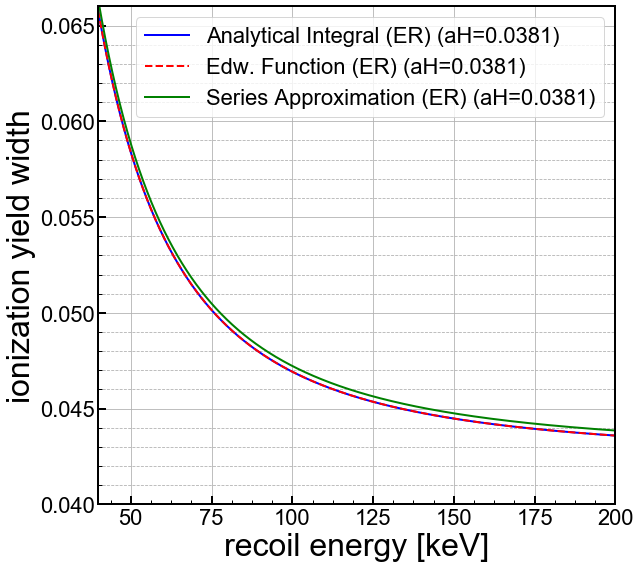

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

mask = [True, True, False, False, True, True, True, True, True]



X=np.arange(0.1,200,0.1)

ax1.plot(X,np.sqrt(pd.analytical_NRQ_var(X,A=1.0,B=0.0,alpha=0.0000001)),color='b',linestyle="-",linewidth=2, \
         label='Analytical Integral (ER) (aH={})'.format(0.0381))
ax1.plot(X,sigQerv(X),color='r',linestyle="--",linewidth=2, \
         label='Edw. Function (ER) (aH={})'.format(0.0381))
ax1.plot(X,np.sqrt(pd.series_NRQ_var(X,A=1.0,B=0.0,alpha=0.0000001)),color='g',linestyle="-",linewidth=2, \
         label='Series Approximation (ER) (aH={})'.format(0.0381))

#ax1.errorbar(xE,qbootsigs, yerr=(qbootsigerrsl,qbootsigerrsu), \
#             color='k', marker='o',markersize=4,linestyle='none',label='ER scatters', linewidth=2)
#ax1.errorbar(E_recoil_ER[mask],sig_ER[mask], yerr=sig_ER_err[mask], \
#             color='k', marker='^',markersize=8,linestyle='none',label='Edw. ER scatters', linewidth=2)




ymin = 0.04
ymax = 0.066



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(40, 200) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('pics/figure.png')
plt.show()

In [11]:
import h5py
filename = 'data/sims.h5'
#remove vars
f = h5py.File(filename,'r')

#save the results for the Edw fit
path='{}/'.format('ER')

xE = np.asarray(f[path+'xE'])
qbootsigs = np.asarray(f[path+'qbootsigs'])
qbootsigerrsu = np.asarray(f[path+'qbootsigerrsu'])
qbootsigerrsl = np.asarray(f[path+'qbootsigerrsl'])


f.close()

In [18]:
#get the resolutions for GGA3
import EdwRes as er

aH=0.0381
V=4.0
C=0.0
sigHv,sigIv,sigQerv,sigH_NRv,sigI_NRv,sigQnrv = er.getEdw_det_res('GGA3',V,'data/edw_res_data.txt',aH,C)

import fano_calc as fc

#recall defaults (filename='test.h5', 
#det='GGA3',band='ER',F=0.00001,V=4.0,alpha=(1/10000.0),aH=0.035,Erv=None,sigv=None,erase=False)
E,sig = fc.RWCalc(filename='data/res_calc.h5')

print(np.shape(E))

(200,)


[20.06374318 10.03193885  6.68803396 ...  0.04359136  0.0435902
  0.04358904]
TEdw: [4.02553791e+02 1.00639797e+02 4.47297983e+01 ... 1.90020659e-03
 1.90010558e-03 1.90000471e-03]
sqrt(TEdw): [20.06374318 10.03193885  6.68803396 ...  0.04359136  0.0435902
  0.04358904]
T1: [3.31500991e+02 8.28765457e+01 3.68349817e+01 ... 1.81369139e-03
 1.81360820e-03 1.81352514e-03]
T2: [1.20311717e+04 7.52155055e+02 1.48641929e+02 ... 1.33262634e-06
 1.33234803e-06 1.33207013e-06]
T3: [7.42890192e+04 4.64310726e+03 9.17171329e+02 ... 4.19451602e-06
 4.19444839e-06 4.19438087e-06]
T4: [4.39075749e+04 2.74497824e+03 5.42466423e+02 ... 4.86339923e-06
 4.86238352e-06 4.86136933e-06]
T5: [2.94667951e+05 1.84169036e+04 3.63795848e+03 ... 1.26899997e-05
 1.26897529e-05 1.26895066e-05]
T6: [9.27019171e+07 1.44848153e+06 1.27166418e+05 ... 8.77424075e-08
 8.77415795e-08 8.77407528e-08]


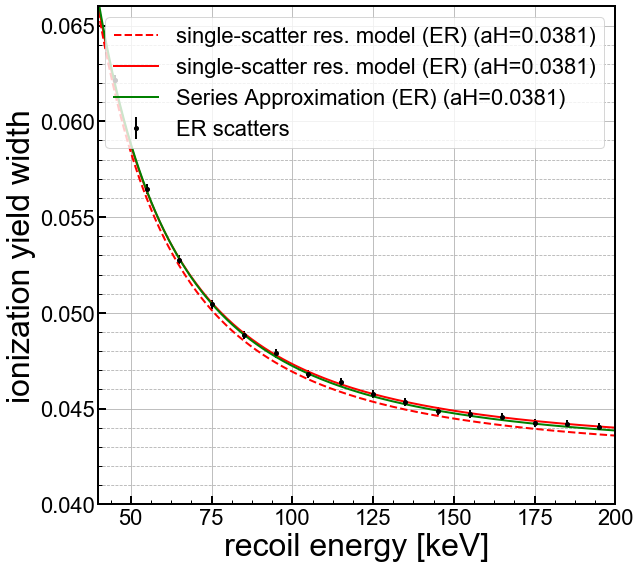

In [20]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

mask = [True, True, False, False, True, True, True, True, True]



X=np.arange(0.1,200,0.1)

print(sigQerv(X))

ax1.plot(X,sigQerv(X),color='r',linestyle="--",linewidth=2, \
         label='single-scatter res. model (ER) (aH={})'.format(aH))
ax1.plot(E,sig,color='r',linestyle="-",linewidth=2, \
         label='single-scatter res. model (ER) (aH={})'.format(aH))
ax1.plot(X,np.sqrt(pd.series_NRQ_var(X,A=1.0,B=0.0,alpha=0.0000001)),color='g',linestyle="-",linewidth=2, \
         label='Series Approximation (ER) (aH={})'.format(0.0381))
ax1.errorbar(xE,qbootsigs, yerr=(qbootsigerrsl,qbootsigerrsu), \
             color='k', marker='o',markersize=4,linestyle='none',label='ER scatters', linewidth=2)
#ax1.errorbar(E_recoil_ER[mask],sig_ER[mask], yerr=sig_ER_err[mask], \
#             color='k', marker='^',markersize=8,linestyle='none',label='Edw. ER scatters', linewidth=2)




ymin = 0.04
ymax = 0.066



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(40, 200) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/paper_figures/ERyieldWidth_Figure2a.eps')
#plt.savefig('figures/paper_figures/ERyieldWidth_Figure2a.pdf')
plt.show()

TEdw: [9.26693123e+01 2.39451885e+01 1.08687697e+01 ... 1.84120352e-04
 1.84113857e-04 1.84107412e-04]
sqrt(TEdw): [9.62649014 4.89338212 3.29678173 ... 0.0135691  0.01356886 0.01356862]
T1: [2.16165808e+01 6.18200486e+00 2.97402074e+00 ... 1.54464515e-04
 1.54473716e-04 1.54482941e-04]
T2: [1.51957422e+03 9.91648689e+01 2.01446481e+01 ... 6.45429841e-08
 6.45187587e-08 6.44945771e-08]
T3: [2.08423511e+04 1.33007437e+03 2.66311704e+02 ... 1.52822591e-07
 1.52860257e-07 1.52897930e-07]
T4: [4.38647658e+03 2.94568929e+02 6.08557603e+01 ... 2.38582502e-07
 2.38494424e-07 2.38406505e-07]
T5: [7.01171794e+04 4.52764390e+03 9.13129804e+02 ... 4.63660265e-07
 4.63768236e-07 4.63876238e-07]
T6: [2.21383726e+07 3.57367356e+05 3.20316916e+04 ... 1.44308862e-09
 1.44359340e-09 1.44409815e-09]


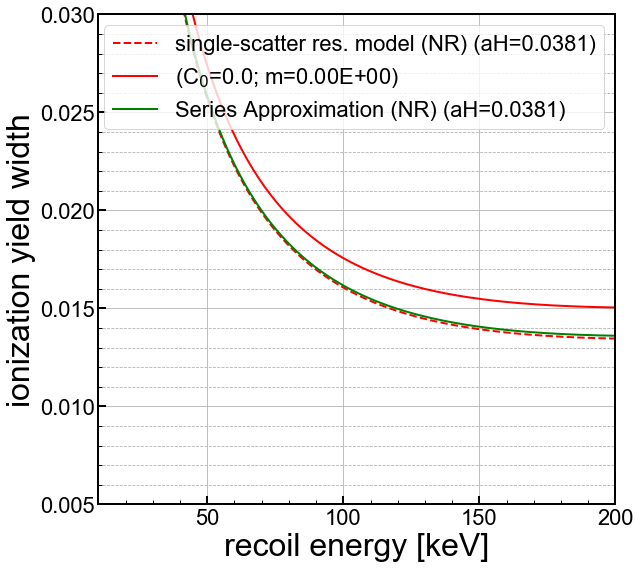

In [22]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

#det='GGA3',band='ER',F=0.00001,V=4.0,alpha=(1/10000.0),aH=0.035,Erv=None,sigv=None,erase=False)
Enr,signr = fc.RWCalc(filename='data/res_calc.h5',alpha=1/18.0,aH=0.0381,band='NR')


ax1.plot(X,sigQnrv(X),color='r',linestyle="--",linewidth=2, \
         label='single-scatter res. model (NR) (aH={})'.format(aH))
#ax1.plot(xl,np.sqrt(Sigss**2),color='r',linestyle="-",linewidth=2, \
#         label='(C$_0$={:01.3}; m={:01.2E})'.format(0.0,0.0))
ax1.plot(Enr,signr,color='r',linestyle="-",linewidth=2, \
         label='(C$_0$={:01.3}; m={:01.2E})'.format(0.0,0.0))
ax1.plot(X,np.sqrt(pd.series_NRQ_var(X,F=0,aH=0.03862,A=0.16,B=0.18,alpha=(1/18.0))),color='g',linestyle="-",linewidth=2, \
         label='Series Approximation (NR) (aH={})'.format(0.0381))



ymin = 0.005
ymax = 0.03



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(10, 200) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/paper_figures/EdwyieldWidthFit_Figure2b.eps')
#plt.savefig('figures/paper_figures/EdwyieldWidthFit_Figure2b.pdf')
plt.show()